In [134]:
# dataset
x = [1, 12, 97, 52, 34, 89, 56]

# bandwidth
h = 0.3

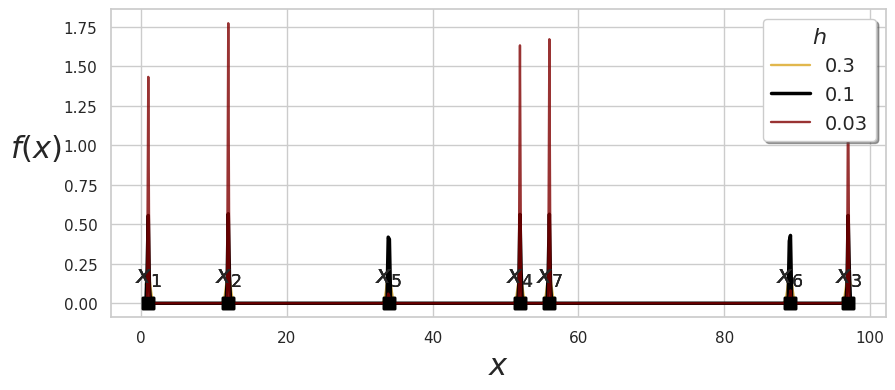

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# the Kernel function
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dummy dataset
dataset = np.array([1, 12, 97, 52, 34, 89, 56])

# x-value range for plotting KDEs
x_range = np.linspace(dataset.min()-0.3, dataset.max()+0.3, num=600)

# bandwith values for experimentation
H = [0.3, 0.1, 0.03]
n_samples = dataset.size

# line properties for different bandwith values
color_list = ['goldenrod', 'black', 'maroon']
alpha_list = [0.8, 1, 0.8]
width_list = [1.7,2.5,1.7]

plt.figure(figsize=(10,4))
# iterate over bandwith values
for h, color, alpha, width in zip(H, color_list, alpha_list, width_list):
    total_sum = 0
    # iterate over datapoints
    for i, xi in enumerate(dataset):
        total_sum += K((x_range - xi) / h)
        plt.annotate(r'$x_{}$'.format(i+1),
                     xy=[xi, 0.13],
                     horizontalalignment='center',
                     fontsize=18,
                    )
    y_range = total_sum/(h*n_samples)
    plt.plot(x_range, y_range, 
             color=color, alpha=alpha, linewidth=width, 
             label=f'{h}')

    plt.plot(dataset, np.zeros_like(dataset) , 's', 
             markersize=8, color='black')
    
plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=20)
plt.legend(fontsize=14, shadow=True, title='$h$', title_fontsize=16)
plt.show()

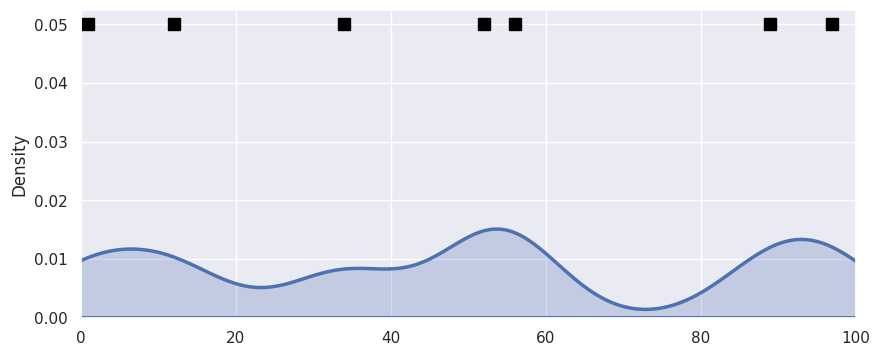

Posición	Puntaje	Premio
1		0.02	Oro
2		0.02	Plata
3		0.02	Bronce
4		0.01	N/A
5		0.01	N/A
6		0.01	N/A
7		0.01	N/A
8		0.01	N/A
9		0.01	N/A
10		0.01	N/A
11		0.01	N/A
12		0.01	N/A
13		0.01	N/A
14		0.01	N/A
15		0.01	N/A
16		0.01	N/A
17		0.01	N/A
18		0.01	N/A
19		0.01	N/A
20		0.01	N/A
21		0.01	N/A
22		0.01	N/A
23		0.01	N/A
24		0.01	N/A
25		0.01	N/A
26		0.01	N/A
27		0.01	N/A
28		0.01	N/A
29		0.01	N/A
30		0.01	N/A
31		0.01	N/A
32		0.01	N/A
33		0.01	N/A
34		0.01	N/A
35		0.01	N/A
36		0.01	N/A
37		0.01	N/A
38		0.01	N/A
39		0.01	N/A
40		0.01	N/A
41		0.01	N/A
42		0.01	N/A
43		0.01	N/A
44		0.01	N/A
45		0.01	N/A
46		0.01	N/A
47		0.01	N/A
48		0.01	N/A
49		0.01	N/A
50		0.01	N/A
51		0.01	N/A
52		0.01	N/A
53		0.01	N/A
54		0.01	N/A
55		0.01	N/A
56		0.01	N/A
57		0.01	N/A
58		0.01	N/A
59		0.01	N/A
60		0.01	N/A
61		0.01	N/A
62		0.01	N/A
63		0.01	N/A
64		0.01	N/A
65		0.01	N/A
66		0.01	N/A
67		0.01	N/A
68		0.01	N/A
69		0.01	N/A
70		0.01	N/A
71		0.01	N/A
72		0.01	N/A
73		0.01	N/A
74		0.01	N/A
75		0.01	N/A
76		0

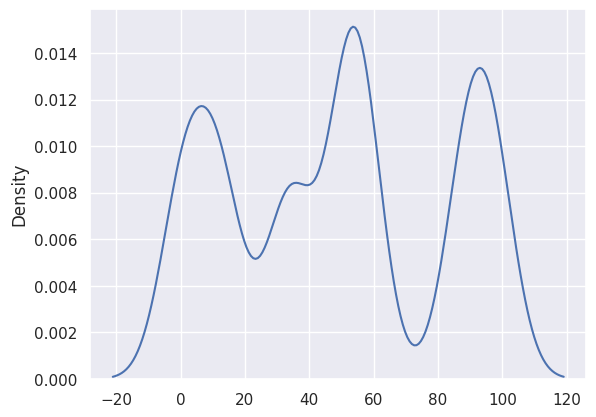

In [136]:
import seaborn as sns
sns.set()

fig, ax = plt.subplots(figsize=(10,4))

sns.kdeplot(ax=ax, data=dataset, 
            bw_adjust=0.3,
            linewidth=2.5, fill=True)

# Definir límites en el eje x
plt.xlim(0, 100)
# plot datapoints
ax.plot(dataset, np.zeros_like(dataset) + 0.05, 's', 
        markersize=8, color='black')
for i, xi in enumerate(dataset):
    plt.annotate(r'$x_{}$'.format(i+1),
                 xy=[xi, 0.1],
                 horizontalalignment='center',
                 fontsize=18,
                )
plt.show()

# 1. Generar un conjunto de datos simulados basados en la distribución KDE
simulated_scores = sns.kdeplot(data=dataset, bw_adjust=0.3).get_lines()[0].get_data()[1]

# 2. Ordenar los puntajes de mayor a menor
simulated_scores_sorted = np.sort(simulated_scores)[::-1]

# 3. Asignar posiciones y premios
num_participants = len(simulated_scores_sorted)
positions = np.arange(1, num_participants + 1)
prizes = ["Oro", "Plata", "Bronce"]  # Puedes definir más premios si es necesario

# Imprimir los resultados
print("Posición\tPuntaje\tPremio")
for position, score in zip(positions, simulated_scores_sorted):
    prize = prizes[position - 1] if position <= len(prizes) else "N/A"
    print(f"{position}\t\t{score:.2f}\t{prize}")

Puntuaciones máximas simuladas ordenadas:
Simulación 1: 92.00
Simulación 2: 92.00
Simulación 3: 92.00
Simulación 4: 92.00
Simulación 5: 92.00
Simulación 6: 92.00
Simulación 7: 92.00
Simulación 8: 92.00
Simulación 9: 92.00
Simulación 10: 92.00
Simulación 11: 92.00
Simulación 12: 92.00
Simulación 13: 92.00
Simulación 14: 92.00
Simulación 15: 92.00
Simulación 16: 92.00
Simulación 17: 92.00
Simulación 18: 92.00
Simulación 19: 92.00
Simulación 20: 92.00
Simulación 21: 92.00
Simulación 22: 92.00
Simulación 23: 92.00
Simulación 24: 92.00
Simulación 25: 92.00
Simulación 26: 92.00
Simulación 27: 92.00
Simulación 28: 92.00
Simulación 29: 92.00
Simulación 30: 92.00
Simulación 31: 92.00
Simulación 32: 92.00
Simulación 33: 92.00
Simulación 34: 92.00
Simulación 35: 92.00
Simulación 36: 92.00
Simulación 37: 92.00
Simulación 38: 92.00
Simulación 39: 92.00
Simulación 40: 92.00
Simulación 41: 92.00
Simulación 42: 92.00
Simulación 43: 92.00
Simulación 44: 92.00
Simulación 45: 92.00
Simulación 46: 92.00
S

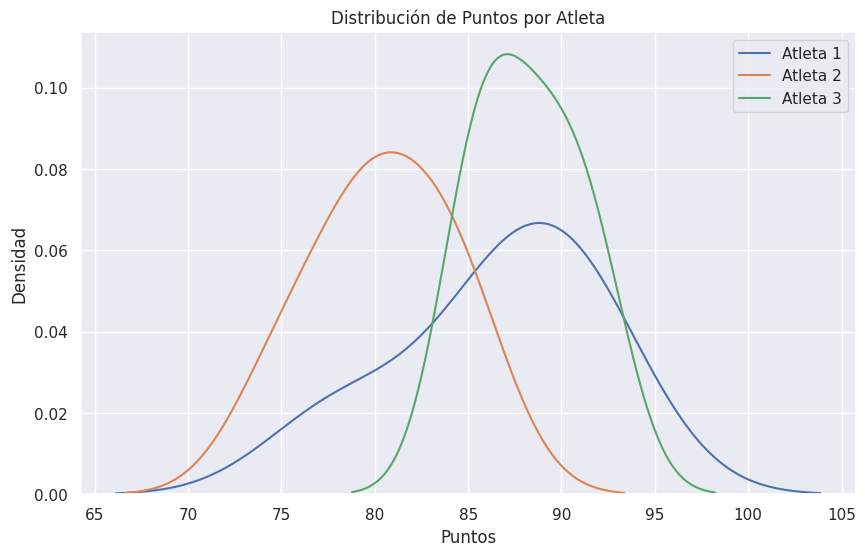

In [137]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'puntos_por_atleta' es un array con los puntos para cada atleta
# Cada fila representa un atleta y cada columna una competición
puntos_por_atleta = np.array([
    [85, 92, 78, 90, 88],  # Atleta 1
    [75, 80, 83, 79, 85],  # Atleta 2
    [90, 88, 86, 92, 85],  # Atleta 3
    # Agrega más atletas si es necesario
])

# Crear una figura para visualizar las distribuciones de puntos de cada atleta
fig, ax = plt.subplots(figsize=(10, 6))

# Crear y graficar la distribución KDE de puntos para cada atleta
for idx, puntos in enumerate(puntos_por_atleta):
    sns.kdeplot(puntos, ax=ax, label=f"Atleta {idx + 1}")

# Simular una competición: muestrear puntuaciones de cada atleta
num_simulaciones = 1000  # Número de simulaciones de la competición
puntuaciones_simuladas = []
for puntos in puntos_por_atleta:
    puntuaciones_simuladas.append(np.random.choice(puntos, size=num_simulaciones))

# Calcular las puntuaciones máximas de cada simulación (por ronda)
puntuaciones_maximas = np.max(puntuaciones_simuladas, axis=0)

# Ordenar las puntuaciones máximas de mayor a menor
puntuaciones_ordenadas = np.sort(puntuaciones_maximas)[::-1]

# Imprimir las puntuaciones máximas ordenadas
print("Puntuaciones máximas simuladas ordenadas:")
for i, score in enumerate(puntuaciones_ordenadas):
    print(f"Simulación {i+1}: {score:.2f}")

# Visualizar la gráfica
plt.legend()
plt.xlabel("Puntos")
plt.ylabel("Densidad")
plt.title("Distribución de Puntos por Atleta")
plt.show()

IndexError: list index out of range

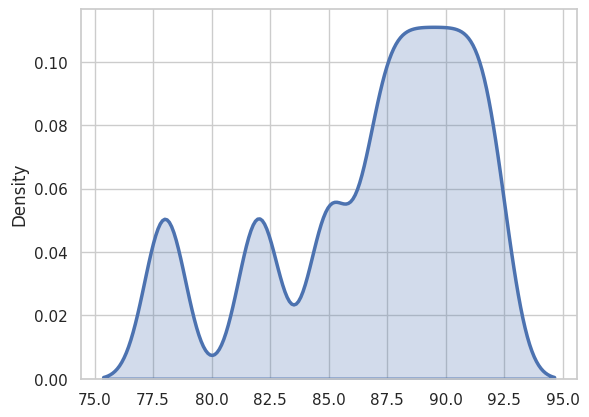

In [139]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que 'puntos_atleta' es un array con los puntos del atleta en competiciones anteriores
puntos_atleta = np.array([85, 92, 78, 90, 88, 82, 87, 91, 89])

# Crear la distribución KDE de los puntos del atleta
sns.set(style="whitegrid")
kde=sns.kdeplot(data=puntos_atleta, 
            bw_adjust=0.3,
            linewidth=2.5, fill=True)

# Simular una competición: obtener un punto de la distribución KDE
# punto_simulado = np.random.choice(puntos_atleta)
x_vals, y_vals = kde.get_lines()[0].get_data()
punto_simulado = np.random.choice(x_vals, p=y_vals)

# Imprimir el resultado simulado
print("Resultado simulado para la próxima competencia:", punto_simulado)

# Visualizar la gráfica
plt.xlabel("Puntos")
plt.ylabel("Densidad")
plt.title("Distribución de Puntos del Atleta")
plt.show()

Resultado simulado para la próxima competencia: 86.07907907907908


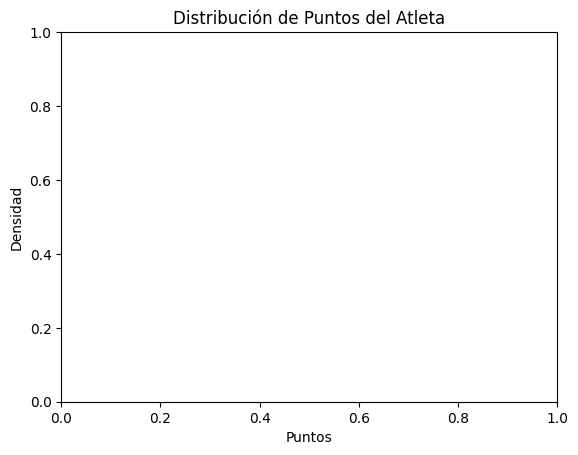

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Supongamos que 'puntos_atleta' es un array con los puntos del atleta en competiciones anteriores
puntos_atleta = np.array([85, 92, 78, 90, 88, 82, 87, 91, 89,1])

# Crear la distribución KDE de los puntos del atleta
kde = gaussian_kde(puntos_atleta)

# Simular una competición: obtener un punto de la distribución KDE
x_vals = np.linspace(np.min(puntos_atleta), np.max(puntos_atleta), 1000)
y_vals = kde.evaluate(x_vals)
punto_simulado = np.random.choice(x_vals, p=y_vals / np.sum(y_vals))

# Imprimir el resultado simulado
print("Resultado simulado para la próxima competencia:", punto_simulado)

# Visualizar la gráfica
plt.xlabel("Puntos")
plt.ylabel("Densidad")
plt.title("Distribución de Puntos del Atleta")
plt.show()

In [16]:
import numpy as np
from scipy.stats import gaussian_kde

# Generar datos de muestra
data = np.array([85, 92, 78, 90, 88, 82, 87, 91, 89,1])
# Crear KDE con kernel Epanechnikov
kde = gaussian_kde(data, bw_method='scott')
kde.set_bandwidth(bw_method=kde.factor * 0.5)  # Ajuste del ancho de banda si es necesario

# Función de kernel Epanechnikov
def epanechnikov_kernel(x):
    return 0.75 * (1 - x**2) * (np.abs(x) <= 1)

# Reemplazar el kernel de Gauss por el de Epanechnikov
kde.covariance_factor = lambda: np.std(data) * len(data) ** (-1 / 5)
kde._compute_covariance()

# Generar datos aleatorios a partir de la distribución KDE
random_samples = kde.resample(size=1000)
re=[]
for i in random_samples[0]:
    if i>= 0.0 and i<=100.0:
        re.append(i)
print(re)

[92.48734621467217, 23.333193199464674, 62.942714939677685, 18.802337442326674, 13.361819083835002, 1.3926925128798473, 78.63677138502156, 32.28290116672023, 31.754961180302715, 54.86431103938627, 32.04299631073866, 34.96493377924759, 95.0641437685808, 36.90331419177348, 95.43439659588587, 88.87738505069274, 32.08084043498542, 73.23345207443072, 56.18307175994708, 26.57485788628488, 98.70924303509997, 37.40443707814357, 68.11201446761481, 24.019327091690556, 10.274935463888298, 67.26410478565924, 54.889908787172836, 31.00024750878798, 5.700306309400176, 40.1782512948086, 57.576729708160855, 92.8502776510122, 78.21150276901665, 27.137973841738223, 43.450197584275, 11.454746076271022, 48.62635623893411, 35.167426404700734, 15.826163821193717, 35.317772316083996, 18.864737668970108, 26.356895673371405, 3.5350416362770147, 36.35649505445724, 92.9581739668499, 78.41667760694534, 60.92333651581947, 93.62803597113215, 70.51434741853797, 74.48695870595947, 42.75960431396435, 55.54351816112681,

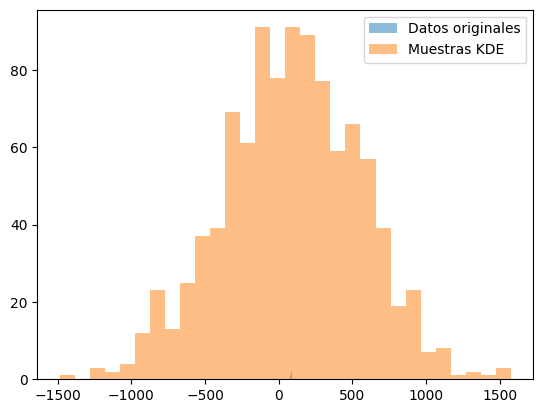

In [6]:
import matplotlib.pyplot as plt

# Visualización de los datos originales
plt.hist(data, bins=30, alpha=0.5, label='Datos originales')

# Visualización de las muestras generadas
plt.hist(random_samples[0], bins=30, alpha=0.5, label='Muestras KDE')

plt.legend(loc='upper right')
plt.show()

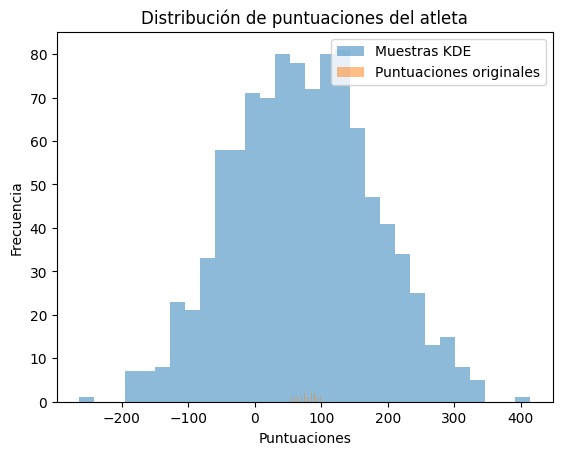

[[ 6.46158879e+01  1.83848806e+02  1.23818663e+02  1.57229565e+02
   1.36321467e+02  2.38741649e+02  7.01320140e+01  4.37999691e+01
   7.20189036e+01 -9.78558573e+01  1.21607807e+02 -5.41435392e+01
   3.70344461e+00  6.65113518e+01  1.02277988e+02  2.86478310e+02
   5.20626525e+01  1.29217292e+02  1.92564334e+02  1.11521321e+02
   1.47247134e+02 -1.25626675e+02 -3.58379850e+01 -9.96249116e+01
   2.51208475e+02  9.44337327e+01  2.40349069e+01  1.72626053e+01
   5.21351132e+01  1.94971316e+02 -6.59285371e+01  1.49962757e+02
   4.91068978e+01  1.58283270e+02  6.52821907e+01 -6.10536174e+01
   1.54367151e+01  2.69308875e+01  1.51976143e+02  1.00051635e+02
  -2.34438273e+01  6.85699663e+01  1.76806631e+02  2.28868988e+02
   1.61975209e+01  4.38157263e+01  2.67284005e+01  5.89195637e+01
   1.68537298e+02  4.45272551e+01  5.08662368e+00  1.10262381e+02
   1.84475259e+02  9.12826594e+01  2.32654596e+01  1.81380177e+02
   1.85691044e+02  6.15181170e+01  1.12011354e+02 -1.39065627e+01
  -2.08674

In [7]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Lista de puntuaciones del atleta
athlete_scores = [75, 80, 85, 90, 70, 65, 95, 100, 55, 60, 75, 85, 90]

# Crear KDE con kernel Epanechnikov
kde = gaussian_kde(athlete_scores, bw_method='scott')
kde.set_bandwidth(bw_method=kde.factor * 0.5)  # Ajuste del ancho de banda si es necesario

# Función de kernel Epanechnikov
def epanechnikov_kernel(x):
    return 0.75 * (1 - x**2) * (np.abs(x) <= 1)

# Reemplazar el kernel de Gauss por el de Epanechnikov
kde.covariance_factor = lambda: np.std(athlete_scores) * len(athlete_scores) ** (-1 / 5)
kde._compute_covariance()

# Generar datos aleatorios a partir de la distribución KDE
random_samples = kde.resample(size=1000)

# Visualización de los resultados
plt.hist(random_samples[0], bins=30, alpha=0.5, label='Muestras KDE')
plt.hist(athlete_scores, bins=30, alpha=0.5, label='Puntuaciones originales')
plt.legend(loc='upper right')
plt.xlabel('Puntuaciones')
plt.ylabel('Frecuencia')
plt.title('Distribución de puntuaciones del atleta')
plt.show()

print(random_samples)

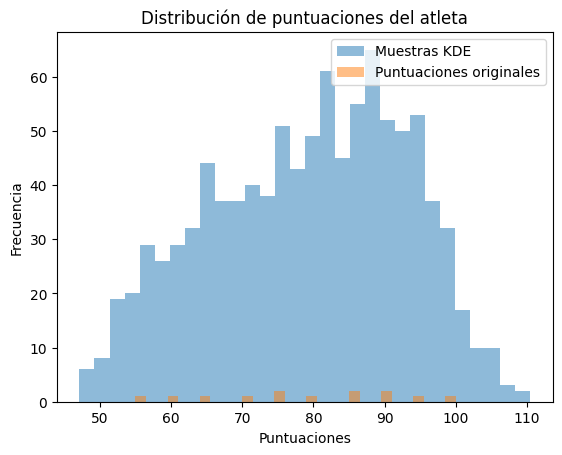

[[ 68.46432329  79.23427477  66.37316814  48.63233284  52.43494963
   64.96443883  76.74528994  91.95282735  93.2264087   64.14933642
   52.32952315  88.29931381  90.16146592  86.22255303  67.91082259
   69.40309654  73.84590545  89.77317641  73.68518548  67.80505994
   65.41238806  90.14100284  61.62226184  80.0580483   55.18535276
   73.68116983  76.1166425   82.21358746  56.60888882  81.23703918
   87.34692236  88.80289354  72.14042801  74.66422235  69.25664555
   53.53453062  97.17433223  81.83516986  49.75013011  88.41890151
   77.48475298  77.57416587  97.11053775  99.7563715   86.63579683
   51.5053402   93.88895257  79.90557149  61.76833786  71.88704996
   96.46767023 101.15333446  82.26165322  99.26143514  90.2156586
   84.92337898  66.27841852  69.42438696  76.91450903  84.24452679
   78.36984503  89.30555707  81.47657383  92.2316088   63.04020417
   71.72533367  89.65916591  76.15188808  82.04436143  94.43457487
   86.85090434  57.51592588  58.18024876  64.75542708  82.89733

In [8]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Lista de puntuaciones del atleta
athlete_scores = [75, 80, 85, 90, 70, 65, 95, 100, 55, 60, 75, 85, 90]

# Crear KDE con kernel Epanechnikov
kde = gaussian_kde(athlete_scores, bw_method='scott')
kde.set_bandwidth(bw_method=kde.factor * 0.5)  # Ajuste del ancho de banda si es necesario

# Generar datos aleatorios a partir de la distribución KDE
random_samples = kde.resample(size=1000)

# Visualización de los resultados
plt.hist(random_samples[0], bins=30, alpha=0.5, label='Muestras KDE')
plt.hist(athlete_scores, bins=30, alpha=0.5, label='Puntuaciones originales')
plt.legend(loc='upper right')
plt.xlabel('Puntuaciones')
plt.ylabel('Frecuencia')
plt.title('Distribución de puntuaciones del atleta')
plt.show()

print(random_samples)

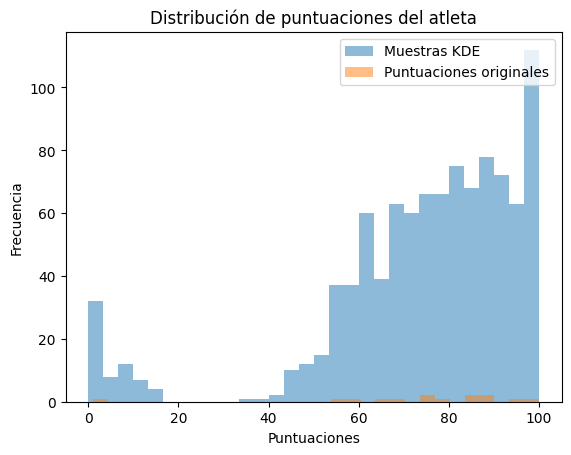

[[1.00000000e+02 9.03393357e+01 8.20782339e+01 8.13632382e+01
  6.33807442e+01 8.97931444e+01 9.01261688e+01 6.73177509e+01
  6.59180900e+01 1.00000000e+02 9.69218293e+01 9.34225422e+01
  8.40602669e+01 7.89481827e+01 7.70200732e+01 6.74356661e+01
  9.84865554e+00 9.05837190e+01 7.03225024e+01 8.60275544e+01
  6.63457443e+01 6.91086483e+01 0.00000000e+00 6.08590464e+01
  5.88557985e+01 0.00000000e+00 8.88321414e+01 8.68242913e+01
  4.39764345e+01 7.31216820e+01 7.16711421e+01 7.97831026e+01
  7.68463861e+01 5.67998648e+01 8.35990443e+01 8.07399493e+01
  5.38064418e+01 8.08928772e+01 8.78896190e+01 6.57656928e+01
  5.60255372e+01 9.33093982e+01 8.58569416e+01 7.19316138e+01
  9.97717868e+01 7.96228189e+01 9.65660245e+01 9.08898193e+01
  5.40115015e+01 7.98439142e+01 9.44036996e+01 1.00000000e+02
  8.61557153e+01 7.69462243e+01 7.10072458e+01 7.57503464e+01
  9.07588460e+01 8.67027063e+01 8.53492919e+00 9.41637553e+01
  5.40526167e+01 6.83106899e+01 8.56444160e+01 6.95584428e+01
  7.0164

In [10]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Lista de puntuaciones del atleta
athlete_scores = [75, 80, 85, 90, 70, 65, 95, 100, 55, 60, 75, 85, 90,1]

# Crear KDE con kernel Epanechnikov
kde = gaussian_kde(athlete_scores, bw_method='scott')
kde.set_bandwidth(bw_method=kde.factor * 0.5)

# Generar datos aleatorios a partir de la distribución KDE
random_samples = kde.resample(size=1000)

# Asegurar que los valores generados están en el rango de 0 a 100
bounded_samples = np.clip(random_samples, 0, 100)

# Visualización de los resultados
plt.hist(bounded_samples[0], bins=30, alpha=0.5, label='Muestras KDE')
plt.hist(athlete_scores, bins=30, alpha=0.5, label='Puntuaciones originales')
plt.legend(loc='upper right')
plt.xlabel('Puntuaciones')
plt.ylabel('Frecuencia')
plt.title('Distribución de puntuaciones del atleta')
plt.show()

print(bounded_samples)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Puntuaciones del atleta
puntuaciones = [75, 80, 85, 70, 90, 95, 88, 77, 82, 93]

# Crear un histograma normalizado de las puntuaciones
hist, bin_edges = np.histogram(puntuaciones, bins=10, range=(0, 100), density=True)

# Definir la función de densidad a partir del histograma
def target_density(x):
    bin_index = np.digitize(x, bin_edges) - 1
    return hist[bin_index] if 0 <= bin_index < len(hist) else 0

# Definir la función de densidad candidata g(x) = 1/100 para x en [0, 100]
def candidate_density(x):
    return 1.0 / 100

# Definir la constante de normalización c tal que f(x) <= c * g(x) para todo x
c = max(hist) * 100  # ya que g(x) = 1/100, multiplicamos por 100

# Método de aceptación-rechazo
def acceptance_rejection(n_samples):
    samples = []
    while len(samples) < n_samples:
        # Generar un candidato de la distribución g(x)
        x_candidate = np.random.uniform(0, 100)
        
        # Generar un número uniforme para la decisión de aceptación
        u = np.random.uniform(0, c * candidate_density(x_candidate))
        
        # Aceptar o rechazar el candidato
        if u <= target_density(x_candidate):
            samples.append(x_candidate)
    
    return np.array(samples)

# Generar muestras utilizando el método de aceptación-rechazo
n_samples = 10000
samples = acceptance_rejection(n_samples)


# Visualizar el histograma de las muestras generadas y la función de densidad objetivo
# x = np.linspace(0, 100, 1000)
# plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Muestras')
# plt.plot(bin_edges[:-1], hist, 'r-', lw=2, label='Densidad estimada')
# plt.xlabel('Puntuación')
# plt.ylabel('Densidad')
# plt.legend()
# plt.title('Generación de muestras basadas en las puntuaciones del atleta')
# plt.show()
for i in samples:
    print(i)

86.5726232163043
88.04287043268963
80.91429701155323
83.51003821561889
87.3953682026137
86.41946866805289
88.53326734334306
81.5428268676785
90.97943732946366
83.8266237055638
77.80577901539941
95.59287811999174
88.92295407801302
96.8349440739953
80.1356767052805
95.98784201086838
87.80365962664956
78.17639473076635
87.09946988808474
92.82814448953198
87.96861377519186
85.70032684376064
83.18794900224772
75.0163084932449
71.34386413449076
78.89705424976862
88.21692919246061
84.18321861074584
81.50593829255389
76.66247414749017
70.8253427686334
70.1931602928699
98.26227339594
92.58824058388687
79.66075889139913
98.1858132992439
83.73525174795218
96.87093976601173
83.86912585412416
71.33392184070662
76.26593560064893
78.94930304499026
73.4721648016437
78.93466295446623
84.47360575328
92.66879597197317
92.96602679650475
80.4728768733517
90.28355454590574
83.72023171268927
89.52731955967859
87.98285183558644
87.2436937546926
93.07821369479913
87.9874558349768
70.23152991252384
74.798791209